# CSCI-UA 473 : Intro to Machine Learning - Final Project

## Device Information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Dec 14 02:46:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Initial Setup

In [3]:
%%capture
# Install Packages
# !pip install open3d

In [ ]:
# Remove Colab sample data
!rm -rf sample_data/

# Kaggle API credentials
%env KAGGLE_USERNAME=<KAGGLE_USERNAME>
%env KAGGLE_KEY=<KAGGLE_KEY>

## Download Dataset

In [5]:
# Download train and test sets
!kaggle competitions download -c csci-ua-473-intro-to-machine-learning-fall22

csci-ua-473-intro-to-machine-learning-fall22.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip data
!unzip -n /content/csci-ua-473-intro-to-machine-learning-fall22.zip

Archive:  /content/csci-ua-473-intro-to-machine-learning-fall22.zip


## Import Packages

In [7]:
import os
import time
import copy

# import open3d as o3d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## Load Data

In [8]:
# Load train set
train_X = torch.load("train/train/trainX.pt")
train_Y = torch.load("train/train/trainY.pt")

# Load test set
test_X = torch.load("test/test/testX.pt")

In [9]:
# Split train set into train/val set
train_size = len(train_X[2])
val_start_idx = int(train_size * 0.7)

val_X = [train_X[0][val_start_idx:, :, :, :, :],
         train_X[1][val_start_idx:, :, :, :],
         train_X[2][val_start_idx:]]

val_Y = [train_Y[0][val_start_idx:, :]]

train_X = [train_X[0][:val_start_idx, :, :, :, :],
           train_X[1][:val_start_idx, :, :, :],
           train_X[2][:val_start_idx]]

train_Y = [train_Y[0][:val_start_idx, :]]

In [10]:
# Profile train/test data
print("----- Total Train Size:", train_size, "-----\n")

print("Length of train_X:", len(train_X))
print("Shape of train_X rgb_images:", train_X[0].shape)
print("Shape of train_X depth_images:", train_X[1].shape)
print("Length of train_X file_ids:", len(train_X[2]), "\n")

print("Length of train_Y:", train_Y[0].shape, "\n")

print("Length of val_X:", len(val_X))
print("Shape of val_X rgb_images:", val_X[0].shape)
print("Shape of val_X depth_images:", val_X[1].shape)
print("Length of val_X file_ids:", len(val_X[2]), "\n")

print("Length of val_Y:", val_Y[0].shape, "\n")

print("----- Total Test Size:", len(test_X[2]), "-----\n")

print("Length of test_X:", len(test_X))
print("Shape of test_X rgb_images:", test_X[0].shape)
print("Shape of test_X depth_images:", test_X[1].shape)
print("Length of test_X file_ids:", len(test_X[2]))

----- Total Train Size: 3396 -----

Length of train_X: 3
Shape of train_X rgb_images: torch.Size([2377, 3, 3, 224, 224])
Shape of train_X depth_images: torch.Size([2377, 3, 224, 224])
Length of train_X file_ids: 2377 

Length of train_Y: torch.Size([2377, 12]) 

Length of val_X: 3
Shape of val_X rgb_images: torch.Size([1019, 3, 3, 224, 224])
Shape of val_X depth_images: torch.Size([1019, 3, 224, 224])
Length of val_X file_ids: 1019 

Length of val_Y: torch.Size([1019, 12]) 

----- Total Test Size: 849 -----

Length of test_X: 3
Shape of test_X rgb_images: torch.Size([849, 3, 3, 224, 224])
Shape of test_X depth_images: torch.Size([849, 3, 224, 224])
Length of test_X file_ids: 849


## Creating a Custom Dataset

In [11]:
class RobotHandDataset(Dataset):
    def __init__(self, X, Y=None, view='top', rgb_transform=None, depth_transform=None, target_transform=None):
        self.rgb_images = X[0]
        self.depth_images = X[1]
        self.file_ids = X[2]

        self.view = 0 if 'top' else 1 if 'left' else 2

        self.robot_states = self.robot_states = Y[0] if Y != None else None

        self.rgb_transform = rgb_transform
        self.target_transform = target_transform
        self.depth_transform = depth_transform

    def __len__(self):
        return self.rgb_images.shape[0]

    def __getitem__(self, idx):
        rgb_image = self.rgb_images[idx][self.view]
        depth_image = self.depth_images[idx][self.view]

        if self.robot_states != None:
            state = self.robot_states[idx]
        
        if self.rgb_transform:
            rgb_image = self.rgb_transform(rgb_image)
        
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)
        
        if self.robot_states != None and self.target_transform:
            label = self.target_transform(label)
        
        rgbd_image = torch.cat((rgb_image, torch.tensor(np.expand_dims(depth_image, 0))), 0)

        # rgbd_image = rgbd_image.permute(1, 2, 0)

        return rgbd_image.float(), state.float()

## Initialize Dataset and DataLoader

In [12]:
def rgb_transform(x):
    x = x / 225.0
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).forward(x)
    return x

def depth_transform(x):
    x = x / 1000.0
    return x

datasets = {
    "train": RobotHandDataset(X=train_X, Y=train_Y, view='top',
                              rgb_transform=rgb_transform, depth_transform=depth_transform),
    "val": RobotHandDataset(X=val_X, Y=val_Y, view='top',
                            rgb_transform=rgb_transform, depth_transform=depth_transform),
    "test": RobotHandDataset(X=test_X, Y=val_Y, view='top',
                             rgb_transform=rgb_transform, depth_transform=depth_transform)
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(datasets['val'], batch_size=32, shuffle=True, num_workers=2),
    'test': DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=2),
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

Current device: cuda:0


## Display Images

Image batch shape: torch.Size([32, 4, 224, 224]) 

Labels batch shape: torch.Size([32, 12]) 

State: tensor([ 0.0787,  0.0482,  0.0984,  0.1089,  0.0059,  0.0522,  0.0304, -0.0388,
        -0.0401,  0.0502,  0.0511,  0.0017]) 



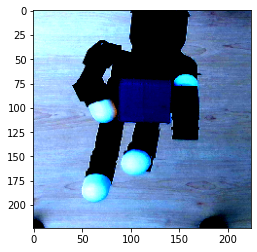

In [13]:
# Display image and label.
train_rgbd_images, train_states = next(iter(dataloaders["train"]))

print(f"Image batch shape: {train_rgbd_images.size()}", "\n")
print(f"Labels batch shape: {train_states.size()}", "\n")

print(f"State: {train_states[0]}", "\n")

img = train_rgbd_images[0][:3,:,:].permute(1, 2, 0).squeeze()
plt.imshow(img)
plt.show()

In [14]:
# color_raw = o3d.geometry.Image(np.array(train_rgbd_images[0][:3,:,:].permute(1, 2, 0)))
# depth_raw = o3d.geometry.Image(np.array(train_rgbd_images[0][:, :, 3]))
# rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw,
#                                                                 depth_scale=1.0,
#                                                                 depth_trunc=3.0,
#                                                                 convert_rgb_to_intensity=True)
# print(rgbd_image)

# plt.subplot(1, 2, 1)
# plt.title('Grayscale Image')
# plt.imshow(rgbd_image.color)
# plt.subplot(1, 2, 2)
# plt.title('Depth Image')
# plt.imshow(rgbd_image.depth)
# plt.show()

## Load Pre-trained Model

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, states in dataloaders[phase]:
                inputs = inputs.to(device)
                states = states.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = torch.sqrt(criterion(outputs, states))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model = resnet50(weights="IMAGENET1K_V2")

# Change num input channels from 3 to 4
weight = model.conv1.weight.data.clone()

model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    model.conv1.weight.data[:, :3] = weight
    model.conv1.weight.data[:, 3] = model.conv1.weight.data[:, 0]


num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, train_states.size(1))

model_ft = model.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=300)

Epoch 0/299
----------
train Loss: 0.0712
val Loss: 0.0608

Epoch 1/299
----------
train Loss: 0.0442
val Loss: 0.0474

Epoch 2/299
----------
train Loss: 0.0358
val Loss: 0.0393

Epoch 3/299
----------
train Loss: 0.0307
val Loss: 0.0364

Epoch 4/299
----------
train Loss: 0.0280
val Loss: 0.0355

Epoch 5/299
----------
train Loss: 0.0257
val Loss: 0.0372

Epoch 6/299
----------
train Loss: 0.0237
val Loss: 0.0264

Epoch 7/299
----------
train Loss: 0.0225
val Loss: 0.0281

Epoch 8/299
----------
train Loss: 0.0224
val Loss: 0.0290

Epoch 9/299
----------
train Loss: 0.0222
val Loss: 0.0297

Epoch 10/299
----------
train Loss: 0.0221
val Loss: 0.0270

Epoch 11/299
----------
train Loss: 0.0219
val Loss: 0.0303

Epoch 12/299
----------
train Loss: 0.0219
val Loss: 0.0278

Epoch 13/299
----------
train Loss: 0.0218
val Loss: 0.0314

Epoch 14/299
----------
train Loss: 0.0218
val Loss: 0.0293

Epoch 15/299
----------
train Loss: 0.0216
val Loss: 0.0254

Epoch 16/299
----------
train Loss

## Generate Output

In [ ]:
outfile = 'submission.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []


In [ ]:
test_data = torch.load('test/test/testX.pt')
file_ids = test_data[-1]

model_ft.eval()

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    outputs = model(inputs)
    preds.append(outputs[0].cpu().detach().numpy())

In [ ]:
df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

In [ ]:
# !kaggle competitions submit -c csci-ua-473-intro-to-machine-learning-fall22 -f submission.csv

---